In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
pd.options.display.float_format = '{:.4f}'.format

In [33]:
# DATA PREPROCESSING
import numpy as np
from citylearn.utilities import read_json
import os

# read the schema
dataset_name = 'citylearn_challenge_2023_phase_3_3'
root_directory = os.path.join("./data", dataset_name)
filepath = os.path.join(root_directory, 'schema.json')
schema = read_json(filepath)
schema['root_directory'] = root_directory

random_seed = 42
np.random.seed(random_seed)

buildings = list(schema['buildings'].keys())
buildings = np.random.choice(buildings, size=2, replace=False).tolist()

print("Active buildings in the schema: ")
for building in schema['buildings']:
    if building in buildings:
        schema['buildings'][building]['include'] = True
        print(building)
    else:
        schema['buildings'][building]['include'] = False


print("\n\nActive observations in the schema: ")
# active_observations = ['hour', 'outdoor_dry_bulb_temperature', 'outdoor_relative_humidity', 'diffuse_solar_irradiance', 'direct_solar_irradiance', 'indoor_dry_bulb_temperature', 'non_shiftable_load', 'solar_generation', 'net_electricity_consumption', 'cooling_device_cop', 'cooling_demand', 'dhw_demand', 'cooling_electricity_consumption', 'dhw_electricity_consumption', 'average_unmet_cooling_setpoint_difference', 'day_type']
active_observations = 'no_change'
for observation in schema['observations']:
    if active_observations == 'no_change':
        if schema['observations'][observation]['active'] == True:
            print(observation)
    elif active_observations == 'all':
        schema['observations'][observation]['active'] = True
        schema['observations'][observation]['shared_in_central_agent'] = True
        print(observation)
    else:
        if observation in active_observations:
            schema['observations'][observation]['active'] = True
            schema['observations'][observation]['shared_in_central_agent'] = True
            print(observation)
        else:
            schema['observations'][observation]['active'] = False
            schema['observations'][observation]['shared_in_central_agent'] = False

print("\n\nActive actions in the schema: ")
active_actions = ['dhw_storage', 'electrical_storage']
for action in schema['actions']:
    if action in active_actions:
        schema['actions'][action]['active'] = True
        print(action)
    else:
        schema['actions'][action]['active'] = False

# Set simulation timeframe (episodes)
schema['simulation_start_time_step'] = 1
lenght_of_simulation_in_days = 30
schema['simulation_end_time_step'] = lenght_of_simulation_in_days * 24

for building in schema['buildings']:
    # Set custom pricing helper buildig
    schema['buildings'][building]['type'] = 'wrappers.CustomPricingWrapper.CustomPricingBuilding'

    # Set pricing data
    schema['buildings'][building]['pricing'] = 'pricing_data_mvm_A2.csv'

    # Set carbon intensity data
    schema['buildings'][building]['carbon_intensity'] = 'carbon_intensity_HU.csv'

print("\n\nReward function: ")
print(schema['reward_function']['type'])
number_of_episodes = 100

Active buildings in the schema: 
Building_1
Building_2


Active observations in the schema: 
day_type
hour
outdoor_dry_bulb_temperature
outdoor_dry_bulb_temperature_predicted_6h
outdoor_dry_bulb_temperature_predicted_12h
outdoor_dry_bulb_temperature_predicted_24h
outdoor_relative_humidity
diffuse_solar_irradiance
diffuse_solar_irradiance_predicted_6h
diffuse_solar_irradiance_predicted_12h
diffuse_solar_irradiance_predicted_24h
direct_solar_irradiance
direct_solar_irradiance_predicted_6h
direct_solar_irradiance_predicted_12h
direct_solar_irradiance_predicted_24h
carbon_intensity
indoor_dry_bulb_temperature
indoor_relative_humidity
non_shiftable_load
solar_generation
dhw_storage_soc
electrical_storage_soc
net_electricity_consumption
electricity_pricing
electricity_pricing_predicted_6h
electricity_pricing_predicted_12h
electricity_pricing_predicted_24h
cooling_demand
dhw_demand
occupant_count
indoor_dry_bulb_temperature_set_point
power_outage


Active actions in the schema: 
dhw_storage
e

In [27]:
from agents.CustomRBC import train_rbc
from rewardFunctions.rewardFunction2 import CustomRewardFunction

action_map = {i: 0.0 for i in range(1, 25)}

rbc_results = train_rbc(
    schema=schema,
    action_map=action_map,
    episodes=number_of_episodes,
    reward_function=CustomRewardFunction
)

IntProgress(value=0, description='Simulating:', max=4175, style=ProgressStyle(bar_color='maroon'))

Number of episodes to train: 25


name,Building_1,Building_2,Building_6,District
cost_function,,,,
annual_normalized_unserved_energy_total,0.0000,0.0000,0.0000,0.0000
annual_peak_average,NaN,NaN,NaN,1.0000
carbon_emissions_total,1.0000,1.0000,1.0000,1.0000
cost_total,1.0000,1.0000,1.0000,1.0000
daily_one_minus_load_factor_average,NaN,NaN,NaN,1.0000
daily_peak_average,NaN,NaN,NaN,1.0000
discomfort_delta_average,0.6055,0.5979,-0.8637,0.1132
discomfort_delta_maximum,2.9403,2.5729,0.9115,2.1416
discomfort_delta_minimum,-1.2696,-2.8264,-3.5559,-2.5506


In [35]:
from agents.DQN import train_dqn
from rewardFunctions.rewardFunction2 import CustomRewardFunction
from typing import Callable

def linear_schedule(initial_value: float) -> Callable[[float], float]:
    """
    Linear learning rate schedule.

    :param initial_value: Initial learning rate.
    :return: schedule that computes
      current learning rate depending on remaining progress
    """
    def func(progress_remaining: float) -> float:
        """
        Progress will decrease from 1 (beginning) to 0.

        :param progress_remaining:
        :return: current learning rate
        """
        return progress_remaining * initial_value

    return func

dqn_kwargs = {
    'learning_starts': 5000,
    'learning_rate': linear_schedule(0.01),
    'buffer_size': 10000,
    # 'batch_size': 32,
    'gamma': 0.99,
    'train_freq': (12, 'step'),
    'gradient_steps': 1,
    'target_update_interval': 24,
    # 'exploration_fraction': 0.5,
    # 'policy_kwargs': dict(
    #     net_arch=[32, 32, 32, 32],
    # )
}

dqn_results = train_dqn(
    agent_kwargs=dqn_kwargs,
    schema=schema,
    action_bins={'electrical_storage': 21, 'dhw_storage': 21},
    episodes=number_of_episodes,
    reward_function=CustomRewardFunction,
    random_seed=random_seed
)

Output()

Number of episodes to train: 100


name,Building_1,Building_2,District
cost_function,,,
annual_normalized_unserved_energy_total,0.0000,0.0000,0.0000
annual_peak_average,NaN,NaN,1.0015
carbon_emissions_total,1.0131,1.0259,1.0195
cost_total,1.0097,1.0184,1.0140
daily_one_minus_load_factor_average,NaN,NaN,0.9930
daily_peak_average,NaN,NaN,1.0029
discomfort_delta_average,-0.7965,0.6650,-0.0658
discomfort_delta_maximum,2.9403,2.7242,2.8322
discomfort_delta_minimum,-3.7872,-2.8264,-3.3068


In [21]:
from agents.A2C import train_a2c
from rewardFunctions.rewardFunction2 import CustomRewardFunction

a2c_kwargs = {
    'learning_rate': 0.01,
    'gamma': 0.95,
}

a2c_results = train_a2c(
    agent_kwargs=a2c_kwargs,
    schema=schema,
    episodes=number_of_episodes,
    reward_function=CustomRewardFunction,
    random_seed=random_seed
)

Output()

Number of episodes to train: 10


name,Building_1,Building_2,Building_6,District
cost_function,,,,
annual_normalized_unserved_energy_total,0.0000,0.0000,0.0000,0.0000
annual_peak_average,NaN,NaN,NaN,1.0018
carbon_emissions_total,1.0089,1.0174,1.0074,1.0112
cost_total,1.0073,1.0136,1.0058,1.0089
daily_one_minus_load_factor_average,NaN,NaN,NaN,0.9962
daily_peak_average,NaN,NaN,NaN,1.0056
discomfort_delta_average,-0.7965,0.6650,-0.6450,-0.2588
discomfort_delta_maximum,2.9403,2.7242,0.9115,2.1920
discomfort_delta_minimum,-3.7872,-2.8264,-3.5559,-3.3898


In [36]:
from agents.SAC import train_sac
from rewardFunctions.rewardFunction2 import CustomRewardFunction
from stable_baselines3.common.noise import NormalActionNoise
import numpy as np
from typing import Callable

n_actions = len(active_actions) * 2
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

def linear_schedule(initial_value: float) -> Callable[[float], float]:
    """
    Linear learning rate schedule.

    :param initial_value: Initial learning rate.
    :return: schedule that computes
      current learning rate depending on remaining progress
    """
    def func(progress_remaining: float) -> float:
        """
        Progress will decrease from 1 (beginning) to 0.

        :param progress_remaining:
        :return: current learning rate
        """
        return progress_remaining * initial_value

    return func

sac_kwargs = {
    'learning_rate': linear_schedule(0.01),
    'gamma': 0.99,
    'train_freq': (12, 'step'),
    'gradient_steps': 2,
    'action_noise': action_noise,
    'target_update_interval': 24,
    # 'policy_kwargs': dict(
    #     net_arch=[128, 128, 128, 128, 128],
    # )
}

sac_results = train_sac(
    agent_kwargs=sac_kwargs,
    schema=schema,
    episodes=number_of_episodes,
    reward_function=CustomRewardFunction,
    random_seed=random_seed
)

Output()

Number of episodes to train: 100


In [69]:
import sys
import numpy as np
test = np.power(2, 30)
print(test)
sys.getsizeof(1073741824)

1073741824


32

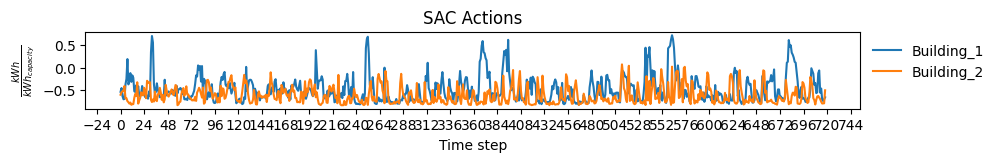

In [19]:
from typing import List
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
%matplotlib inline

def plot_actions(actions_list: List[List[float]], title: str) -> plt.Figure:
    """Plots action time series for different buildings

    Parameters
    ----------
    actions_list: List[List[float]]
        List of actions where each element with index, i,
        in list is a list of the actions for different buildings
        taken at time step i.
    title: str
        Plot axes title

    Returns
    -------
    fig: plt.Figure
        Figure with plotted axes

    """

    fig, ax = plt.subplots(1, 1, figsize=(10, 1))
    columns = [b.name for b in sac_results['env'].buildings]
    actions_list = [[inner[1], inner[3]] for inner in actions_list]
    plot_data = pd.DataFrame(actions_list, columns=columns)
    x = list(range(plot_data.shape[0]))

    for c in plot_data.columns:
        y = plot_data[c].tolist()
        ax.plot(x, y, label=c)

    ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0)
    ax.set_xlabel('Time step')
    ax.set_ylabel(r'$\frac{kWh}{kWh_{capacity}}$')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(24))
    ax.set_title(title)

    return fig

fig = plot_actions(sac_results['actions'], 'SAC Actions')
plt.show()

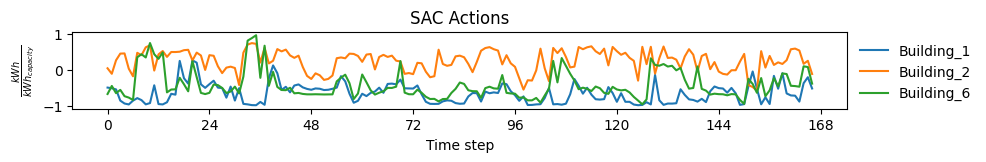

In [12]:
from typing import List
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
%matplotlib inline

def plot_actions(actions_list: List[List[float]], title: str) -> plt.Figure:
    """Plots action time series for different buildings

    Parameters
    ----------
    actions_list: List[List[float]]
        List of actions where each element with index, i,
        in list is a list of the actions for different buildings
        taken at time step i.
    title: str
        Plot axes title

    Returns
    -------
    fig: plt.Figure
        Figure with plotted axes

    """

    fig, ax = plt.subplots(1, 1, figsize=(10, 1))
    columns = [b.name for b in sac_results['env'].buildings]
    actions_list = [[inner[0], inner[2], inner[4]] for inner in actions_list]
    plot_data = pd.DataFrame(actions_list, columns=columns)
    x = list(range(plot_data.shape[0]))

    for c in plot_data.columns:
        y = plot_data[c].tolist()
        ax.plot(x, y, label=c)

    ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0)
    ax.set_xlabel('Time step')
    ax.set_ylabel(r'$\frac{kWh}{kWh_{capacity}}$')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(24))
    ax.set_title(title)

    return fig

fig = plot_actions(sac_results['actions'], 'SAC Actions')
plt.show()

In [54]:
from stable_baselines3.a2c import A2C
from citylearn.citylearn import CityLearnEnv
from citylearn.wrappers import NormalizedObservationWrapper, StableBaselines3Wrapper
from helpers.custom_callback import CustomCallback

a2c_env = CityLearnEnv(schema, central_agent=True)

a2c_env.reward_function = CustomRewardFunction(a2c_env)

a2c_env = NormalizedObservationWrapper(a2c_env)
a2c_env = StableBaselines3Wrapper(a2c_env)

a2c_model = A2C("MlpPolicy", a2c_env, seed=random_seed)

total_timesteps = number_of_episodes * sac_env.time_steps
print(total_timesteps)
a2c_callback = CustomCallback(a2c_env, total_timesteps=total_timesteps)
a2c_model.learn(total_timesteps=a2c_env.time_steps * number_of_episodes, progress_bar=True, callback=a2c_callback)

observations = a2c_env.reset()

while not a2c_env.done:
    actions, _ = a2c_model.predict(observations, deterministic=True)
    observations, _, _, _ = a2c_env.step(actions) 

# print cost functions at the end of episode
kpis = a2c_env.evaluate()
kpis = kpis.pivot(index='cost_function', columns='name', values='value')
kpis = kpis.dropna(how='all')
display(kpis)

Output()

840


: 

In [13]:
from typing import List
import matplotlib.pyplot as plt

def plot_rewards(ax: plt.Axes, rewards: List[float], title: str) -> plt.Axes:
    """Plots rewards over training episodes.

    Parameters
    ----------
    rewards: List[float]
        List of reward sum per episode.
    title: str
        Plot axes title

    Returns
    -------
    ax: plt.Axes
        Plotted axes
    """

    ax.plot(rewards)
    ax.set_xlabel('Episode')
    ax.set_ylabel('Reward')
    ax.set_title(title)

    return ax

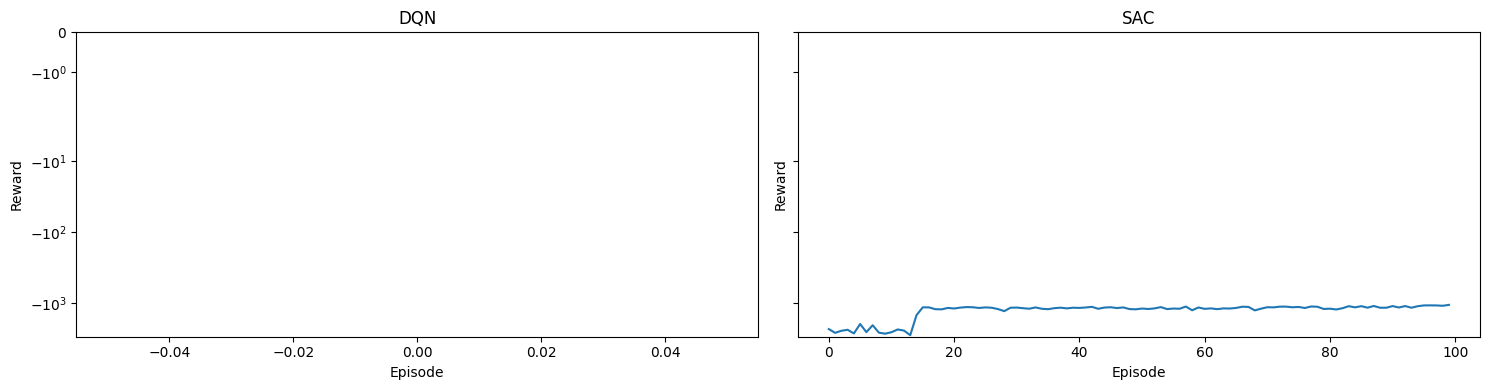

In [20]:
%matplotlib inline

rewards = {
    'DQN': dqn_results['rewards'],
    'SAC': sac_results['rewards'],
    # 'A2C': a2c_callback.reward_history[:number_of_episodes],
    # 'DDPG': ddpg_callback.reward_history[:number_of_episodes],
    # 'TD3': td3_callback.reward_history[:number_of_episodes],
    # 'PPO': ppo_callback.reward_history[:number_of_episodes]
}

min_value = min(min(rewards[key]) for key in rewards)
max_value = max(max(rewards[key]) for key in rewards)

round_factor = 10 ** np.floor(np.log10(max(abs(min_value), abs(max_value))))
min_value = np.floor(min_value / round_factor) * round_factor
max_value = np.ceil(max_value / round_factor) * round_factor

fig, axs = plt.subplots(1, len(rewards), figsize=(15, 4), sharey=True)

# rbc_rewards = [episode_reward['sum'][0] for episode_reward in rbc_results['env'].episode_rewards]
for ax, (k, v) in zip(fig.axes, rewards.items()):
    # ax.plot(rbc_rewards, 'r--', label='RBC')
    ax = plot_rewards(ax, v, k)
    ax.set_ylim(min_value, max_value)
    # ax.set_xlim(0, number_of_episodes - 1)
    ax.set_yscale(value='symlog')

plt.tight_layout()
plt.show()

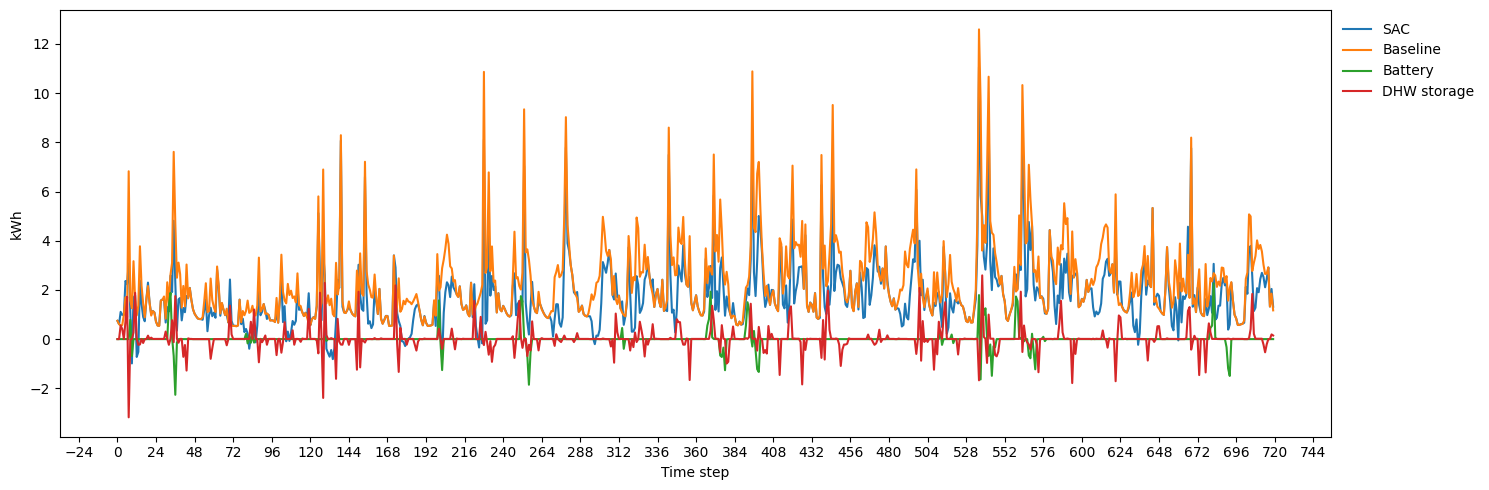

In [23]:
import matplotlib.ticker as ticker
%matplotlib inline

envs = {
    # 'RBC': rbc_results['env'],
    # 'DQN': dqn_results['env'],
    'SAC': sac_results['env'],
    # 'A2C': a2c_results['env'],
    # 'DDPG': ddpg_env,
    # 'TD3': td3_env,
    # 'PPO': ppo_env
}

figsize = (15.0, 5)
fig, ax = plt.subplots(1, 1, figsize=figsize)

for k, v in envs.items():
    y = v.net_electricity_consumption
    x = range(len(y))
    ax.plot(x, y, label=k)

y = v.net_electricity_consumption_without_storage_and_pv
ax.plot(x, y, label='Baseline')
# y = v.solar_generation
# ax.plot(x, y, label='Solar')
y = v.electrical_storage_electricity_consumption
ax.plot(x, y, label='Battery')
# y = v.energy_from_cooling_device
# ax.plot(x, y, label='Heat pump')
# y = v.dhw_electricity_consumption
# # ax.plot(x, y, label='DHW consumption')
y = v.dhw_storage_electricity_consumption
ax.plot(x, y, label='DHW storage')

ax.set_xlabel('Time step')
ax.set_ylabel('kWh')
# ax.set_xlim(120, 160)
ax.xaxis.set_major_locator(ticker.MultipleLocator(24))
ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0)

plt.tight_layout()

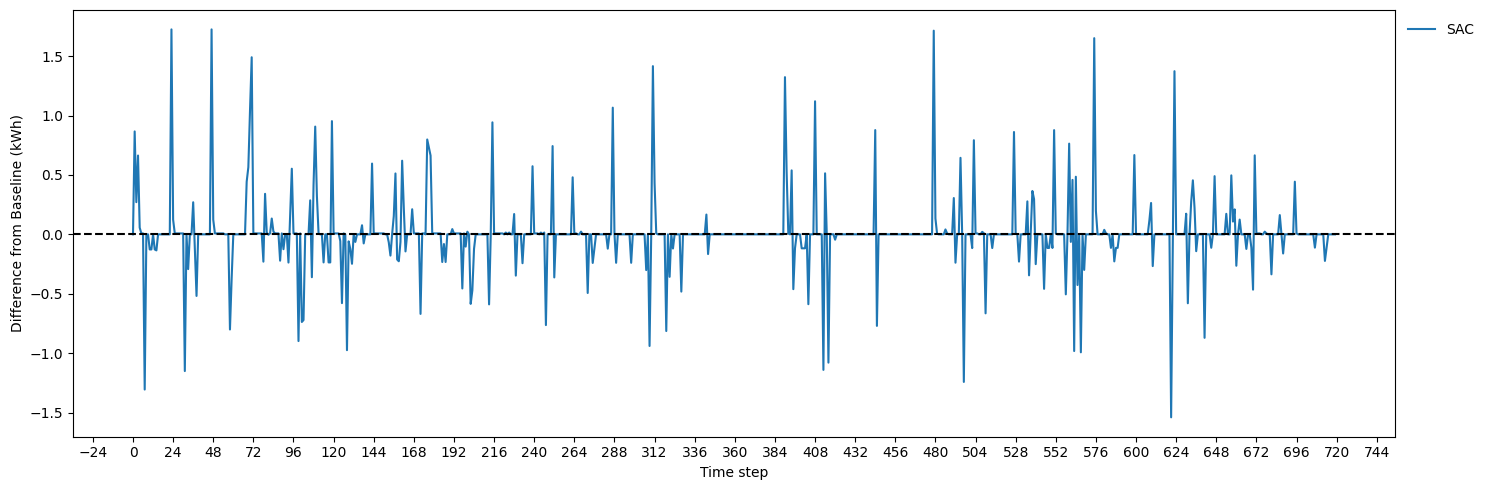

In [13]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

envs = {
    'SAC': sac_results['env'],
    # 'DQN': dqn_env,
    # 'A2C': a2c_env,
    # 'DDPG': ddpg_env,
    # 'TD3': td3_env,
    # 'PPO': ppo_env
}

figsize = (15.0, 5)
fig, ax = plt.subplots(1, 1, figsize=figsize)

baseline = sac_results['env'].net_electricity_consumption_without_storage

for k, v in envs.items():
    y_difference = [y - base for y, base in zip(v.net_electricity_consumption, baseline)]
    x = range(len(y_difference))
    ax.plot(x, y_difference, label=k)

ax.axhline(y=0, color='black', linestyle='--')  # Add a horizontal line at y=0 for reference
ax.set_xlabel('Time step')
ax.set_ylabel('Difference from Baseline (kWh)')
ax.xaxis.set_major_locator(ticker.MultipleLocator(24))
ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0)

plt.tight_layout()
plt.show()

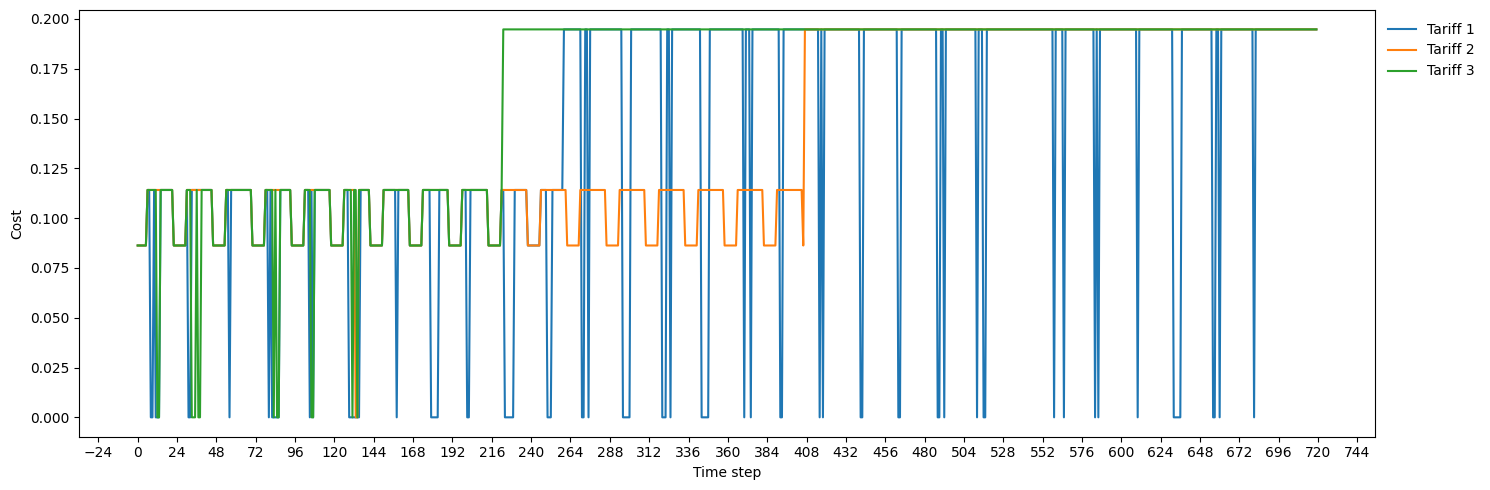

In [15]:
import matplotlib.ticker as ticker
%matplotlib inline

envs = {
    # 'DQN': dqn_env,
    'SAC': sac_results['env'],
    # 'A2C': a2c_env,
    # 'DDPG': ddpg_env,
    # 'TD3': td3_env,
    # 'PPO': ppo_env
}

figsize = (15.0, 5)
fig, ax = plt.subplots(1, 1, figsize=figsize)

for k, v in envs.items():
    y = [cost / consumption if consumption != 0 else 0 for cost, consumption in zip(v.buildings[0].net_electricity_consumption_cost, v.buildings[0].net_electricity_consumption)]
    x = range(len(y))
    ax.plot(x, y, label='Tariff 1')
    y = [cost / consumption if consumption != 0 else 0 for cost, consumption in zip(v.buildings[1].net_electricity_consumption_cost, v.buildings[1].net_electricity_consumption)]
    x = range(len(y))
    ax.plot(x, y, label='Tariff 2')
    y = [cost / consumption if consumption != 0 else 0 for cost, consumption in zip(v.buildings[2].net_electricity_consumption_cost, v.buildings[2].net_electricity_consumption)]
    x = range(len(y))
    ax.plot(x, y, label='Tariff 3')

ax.set_xlabel('Time step')
ax.set_ylabel('Cost')
ax.xaxis.set_major_locator(ticker.MultipleLocator(24))
ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0)
# ax.set_ylim(0, 1)

plt.tight_layout()

In [ ]:
import pandas as pd

def get_kpis(env: CityLearnEnv) -> pd.DataFrame:
    """Returns evaluation KPIs.

    Electricity consumption, cost and carbon emissions KPIs are provided
    at the building-level and average district-level. Average daily peak,
    ramping and (1 - load factor) KPIs are provided at the district level.

    Parameters
    ----------
    env: CityLearnEnv
        CityLearn environment instance.

    Returns
    -------
    kpis: pd.DataFrame
        KPI table.
    """

    kpis = env.evaluate()

    # names of KPIs to retrieve from evaluate function
    kpi_names = [
        'electricity_consumption_total', 'cost_total', 'carbon_emissions_total',
        'daily_peak_average', 'ramping_average', 'monthly_one_minus_load_factor_average'
    ]
    kpis = kpis[
        (kpis['cost_function'].isin(kpi_names))
    ].dropna()

    # round up the values to 3 decimal places for readability
    kpis['value'] = kpis['value'].round(3)

    # rename the column that defines the KPIs
    kpis = kpis.rename(columns={'cost_function': 'kpi'})

    return kpis

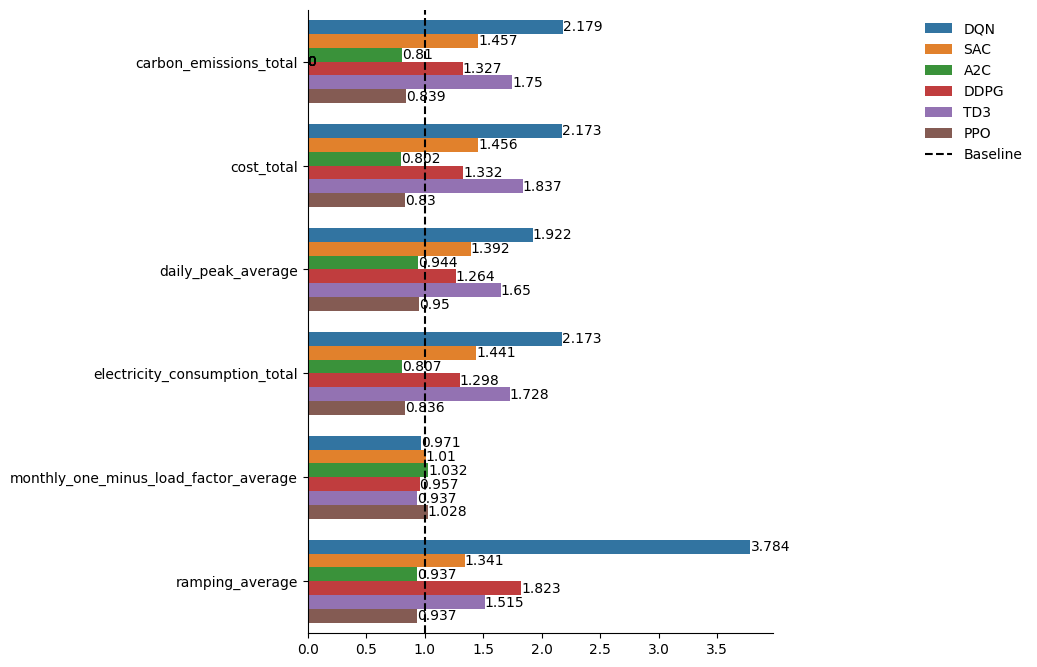

In [ ]:
import seaborn as sns

envs = {
    'DQN': dqn_env,
    'SAC': sac_env,
    'A2C': a2c_env,
    'DDPG': ddpg_env,
    'TD3': td3_env,
    'PPO': ppo_env
}

kpis_list = []

for k, v in envs.items():
    kpis = get_kpis(v)
    kpis = kpis[kpis['level']=='district'].copy()
    kpis['env_id'] = k
    kpis_list.append(kpis)

kpis = pd.concat(kpis_list, ignore_index=True, sort=False)
row_count = 1
column_count = 1
env_count = len(envs)
kpi_count = len(kpis['kpi'].unique())
figsize = (6.0*column_count, 0.225*env_count*kpi_count*row_count)
fig, ax = plt.subplots(row_count, column_count, figsize=figsize)
sns.barplot(x='value', y='kpi', data=kpis, hue='env_id', ax=ax)
ax.axvline(1.0, color='black', linestyle='--', label='Baseline')
ax.set_xlabel(None)
ax.set_ylabel(None)

for s in ['right','top']:
    ax.spines[s].set_visible(False)

for p in ax.patches:
    ax.text(
        p.get_x() + p.get_width(),
        p.get_y() + p.get_height()/2.0,
        p.get_width(), ha='left', va='center'
    )

ax.legend(loc='upper left', bbox_to_anchor=(1.3, 1.0), framealpha=0.0)

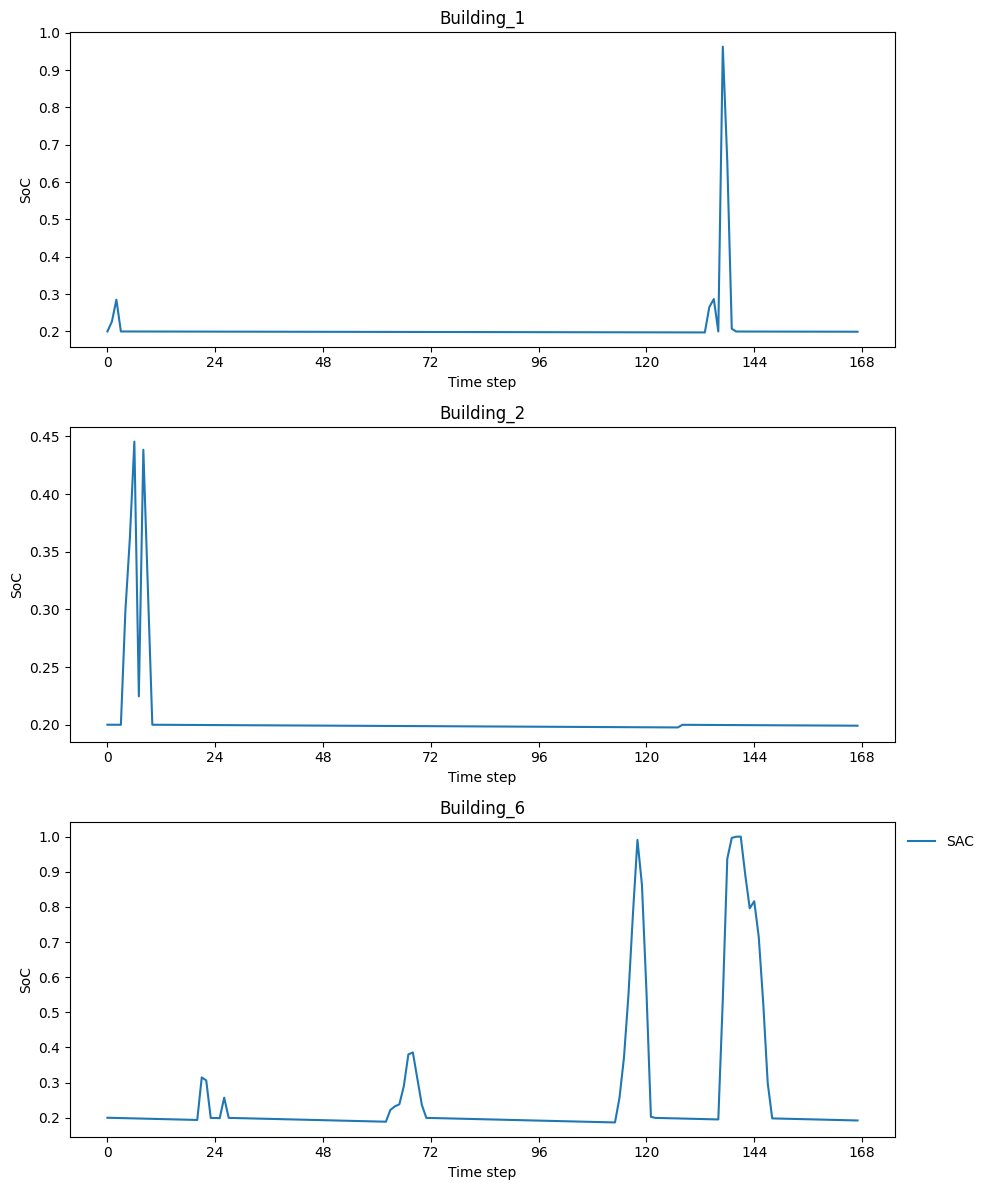

In [68]:
import math

envs = {
    # 'DQN': dqn_env,
    'SAC': sac_env,
    # 'A2C': a2c_env,
    # 'DDPG': ddpg_env,
    # 'TD3': td3_env,
    # 'PPO': ppo_env
}

building_count = len(list(envs.values())[0].buildings)
column_count_limit = 1
row_count = math.ceil(building_count/column_count_limit)
column_count = min(column_count_limit, building_count)
figsize = (10.0*column_count, 4*row_count)
fig, _ = plt.subplots(row_count, column_count, figsize=figsize)

for i, ax in enumerate(fig.axes):
    for k, v in envs.items():
        soc = np.array(v.buildings[i].electrical_storage.soc)
        capacity = v.buildings[i].electrical_storage.capacity_history[0]
        y = soc
        x = range(len(y))
        ax.plot(x, y, label=k)

    ax.set_title(v.buildings[i].name)
    ax.set_xlabel('Time step')
    ax.set_ylabel('SoC')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(24))

    if i == building_count - 1:
        ax.legend(
            loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0
        )
    else:
        ax.legend().set_visible(False)


plt.tight_layout()

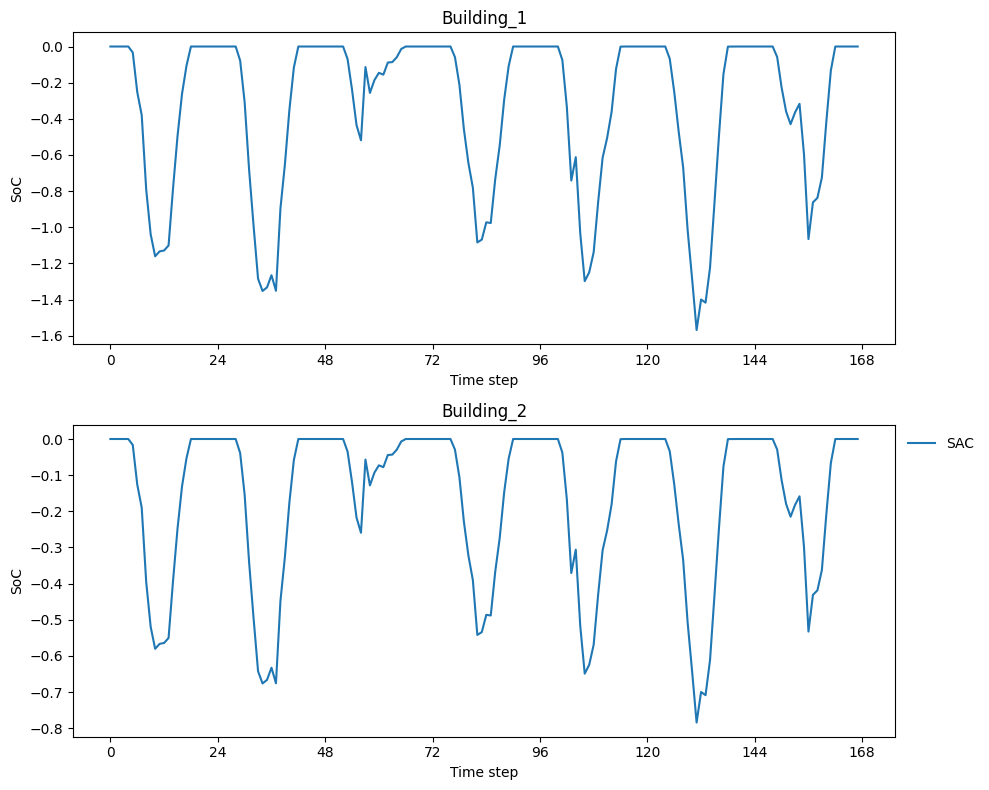

In [79]:
import math

envs = {
    # 'DQN': dqn_env,
    'SAC': sac_env,
    # 'A2C': a2c_env,
    # 'DDPG': ddpg_env,
    # 'TD3': td3_env,
    # 'PPO': ppo_env
}

building_count = len(list(envs.values())[0].buildings)
column_count_limit = 1
row_count = math.ceil(building_count/column_count_limit)
column_count = min(column_count_limit, building_count)
figsize = (10.0*column_count, 4*row_count)
fig, _ = plt.subplots(row_count, column_count, figsize=figsize)

for i, ax in enumerate(fig.axes):
    for k, v in envs.items():
        soc = np.array(v.buildings[i].solar_generation)
        capacity = v.buildings[i].electrical_storage.capacity_history[0]
        y = soc
        x = range(len(y))
        ax.plot(x, y, label=k)

    ax.set_title(v.buildings[i].name)
    ax.set_xlabel('Time step')
    ax.set_ylabel('SoC')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(24))

    if i == building_count - 1:
        ax.legend(
            loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0
        )
    else:
        ax.legend().set_visible(False)


plt.tight_layout()

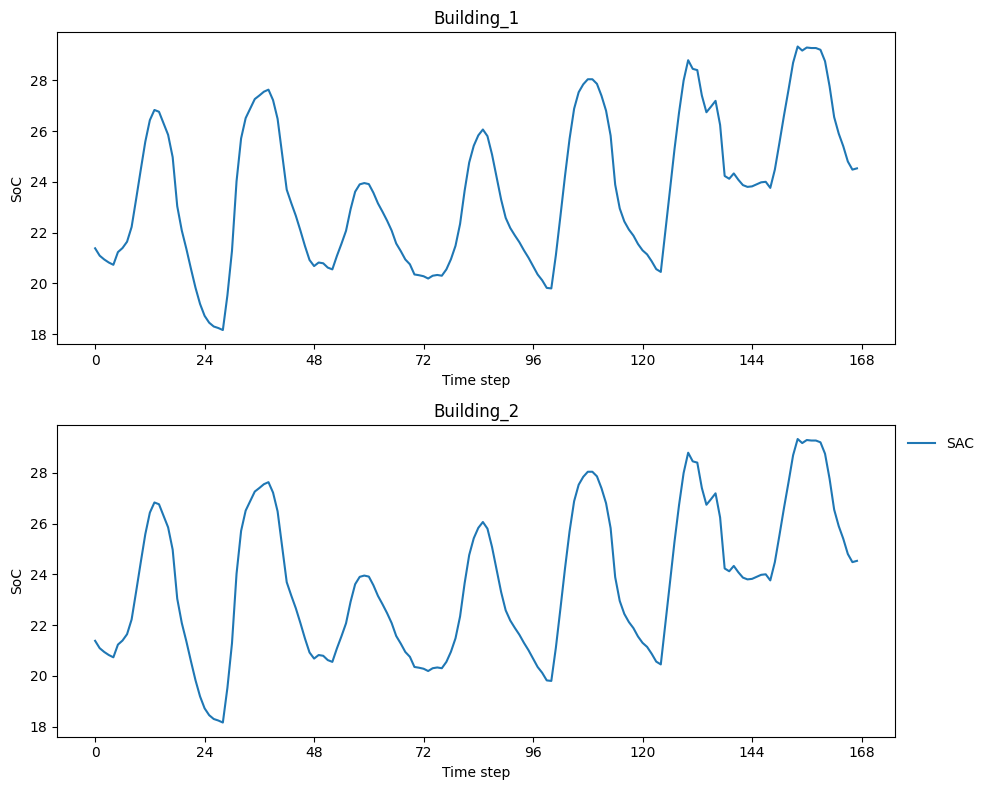

In [33]:
import math

envs = {
    # 'DQN': dqn_env,
    'SAC': sac_env,
    # 'A2C': a2c_env,
    # 'DDPG': ddpg_env,
    # 'TD3': td3_env,
    # 'PPO': ppo_env
}

building_count = len(list(envs.values())[0].buildings)
column_count_limit = 1
row_count = math.ceil(building_count/column_count_limit)
column_count = min(column_count_limit, building_count)
figsize = (10.0*column_count, 4*row_count)
fig, _ = plt.subplots(row_count, column_count, figsize=figsize)

for i, ax in enumerate(fig.axes):
    for k, v in envs.items():
        soc = np.array(v.buildings[i].weather.outdoor_dry_bulb_temperature)
        capacity = v.buildings[i].electrical_storage.capacity_history[0]
        y = soc
        x = range(len(y))
        ax.plot(x, y, label=k)

    ax.set_title(v.buildings[i].name)
    ax.set_xlabel('Time step')
    ax.set_ylabel('SoC')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(24))

    if i == building_count - 1:
        ax.legend(
            loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0
        )
    else:
        ax.legend().set_visible(False)


plt.tight_layout()

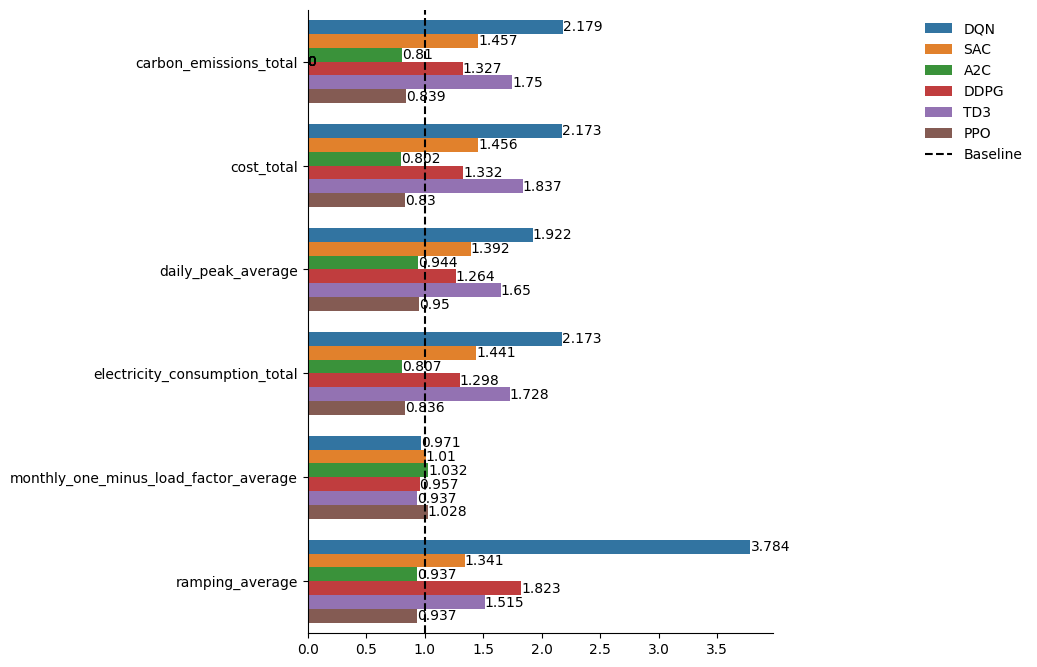

In [ ]:
import seaborn as sns

envs = {
    'DQN': dqn_env,
    # 'DQNR': dqnr_env,
    'SAC': sac_env,
    'A2C': a2c_env,
    'DDPG': ddpg_env,
    'TD3': td3_env,
    'PPO': ppo_env,
    # 'SACR': sacr_env
}

kpis_list = []

for k, v in envs.items():
    kpis = get_kpis(v)
    kpis = kpis[kpis['level']=='district'].copy()
    kpis['env_id'] = k
    kpis_list.append(kpis)

kpis = pd.concat(kpis_list, ignore_index=True, sort=False)
row_count = 1
column_count = 1
env_count = len(envs)
kpi_count = len(kpis['kpi'].unique())
figsize = (6.0*column_count, 0.225*env_count*kpi_count*row_count)
fig, ax = plt.subplots(row_count, column_count, figsize=figsize)
sns.barplot(x='value', y='kpi', data=kpis, hue='env_id', ax=ax)
ax.axvline(1.0, color='black', linestyle='--', label='Baseline')
ax.set_xlabel(None)
ax.set_ylabel(None)

for s in ['right','top']:
    ax.spines[s].set_visible(False)

for p in ax.patches:
    ax.text(
        p.get_x() + p.get_width(),
        p.get_y() + p.get_height()/2.0,
        p.get_width(), ha='left', va='center'
    )

ax.legend(loc='upper left', bbox_to_anchor=(1.3, 1.0), framealpha=0.0)

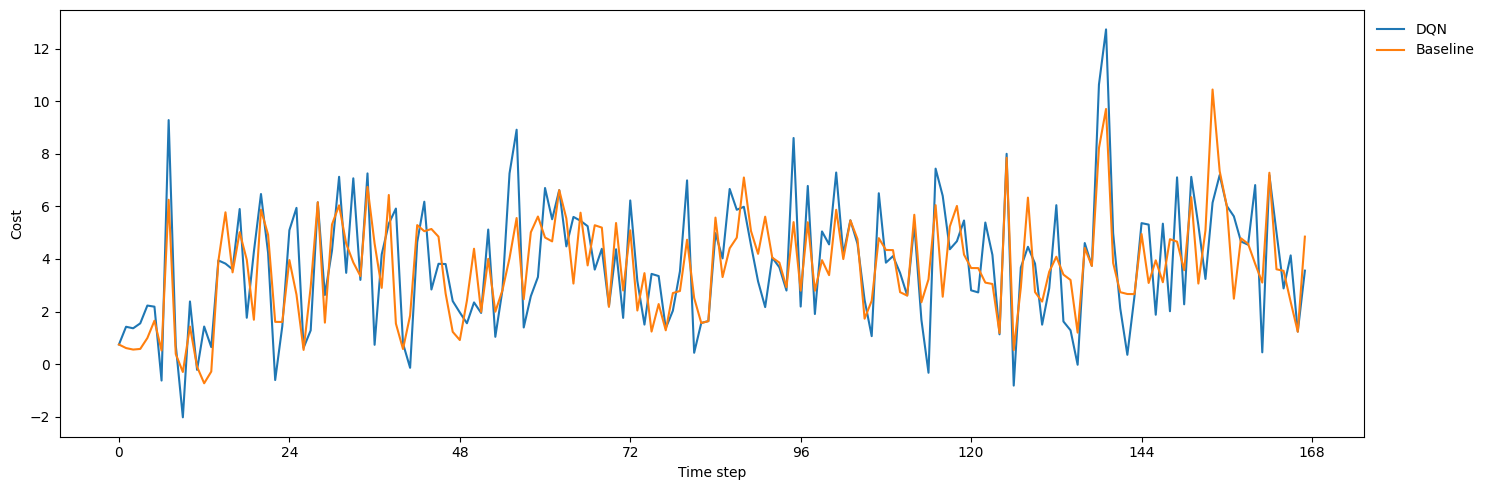

In [42]:
import matplotlib.ticker as ticker

envs = {
    # "DQNR": dqnr_env,
    'DQN': dqn_env,
    # 'SAC': sac_env,
    # 'A2C': a2c_env,
    # 'DDPG': ddpg_env,
    # 'TD3': td3_env,
    # 'PPO': ppo_env
}

figsize = (15.0, 5)
fig, ax = plt.subplots(1, 1, figsize=figsize)

for k, v in envs.items():
    y = v.net_electricity_consumption
    x = range(len(y))
    ax.plot(x, y, label=k)

y = v.net_electricity_consumption_without_storage
ax.plot(x, y, label='Baseline')
ax.set_xlabel('Time step')
ax.set_ylabel('Cost')
ax.xaxis.set_major_locator(ticker.MultipleLocator(24))
ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0)

plt.tight_layout()

ValueError: x and y must have same first dimension, but have shapes (24,) and (0,)

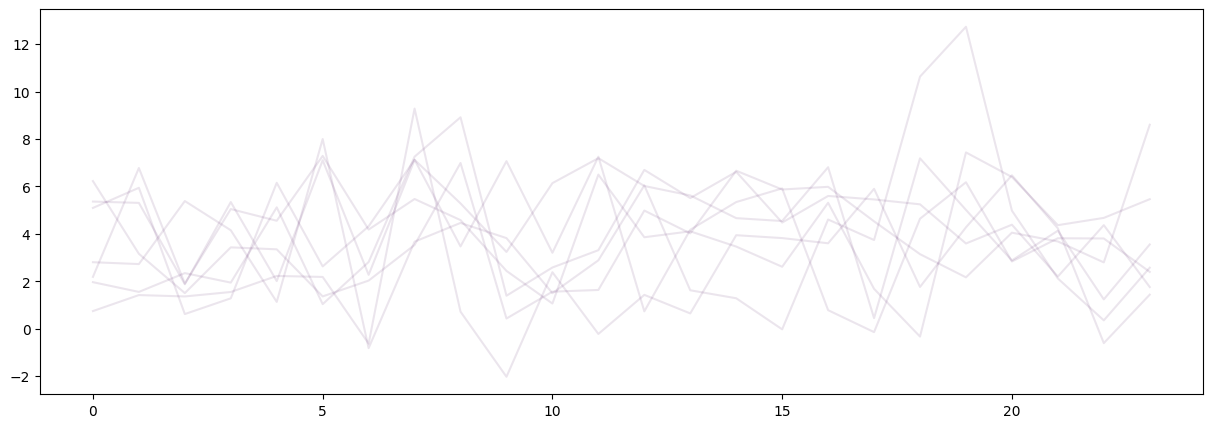

In [41]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

envs = {
    # "Baseline": rbc_env,
    # "DQNR": dqnr_env,
    'DQN': dqn_env,
    # 'SAC': sac_env,
    # 'A2C': a2c_env,
    # 'DDPG': ddpg_env,
    # 'TD3': td3_env,
    # 'PPO': ppo_env
}

figsize = (15.0, 5)
fig, ax = plt.subplots(1, 1, figsize=figsize)

# Calculate daily averages
daily_averages = np.zeros((len(envs), 24))
for i, (k, v) in enumerate(envs.items()):
    y = v.net_electricity_consumption
    for j in range(7):  # 7 days in a week
        daily_averages[i] += y[j*24:(j+1)*24]
    daily_averages[i] /= 7

x = range(24)  # 24 hours in a day
colors = plt.cm.viridis(np.linspace(0, 1, len(envs)))
# Plot individual daily lines with opacity
for i, (k, v) in enumerate(envs.items()):
    y = v.net_electricity_consumption
    color = colors[i]
    for j in range(30):  # 7 days in a week
        ax.plot(x, y[j*24:(j+1)*24], color=color, alpha=0.1)

# Plot thick average line
for i, (k, v) in enumerate(envs.items()):
    color = colors[i]
    ax.plot(x, daily_averages[i], color=color, label=f'{k} Daily Average', linewidth=2)

# Calculate and plot daily averages for the baseline
y_baseline = v.net_electricity_consumption_without_storage
baseline_daily_average = np.mean(y_baseline.reshape(-1, 24), axis=0)
ax.plot(range(24), baseline_daily_average, label='No Storage Daily Average', color='black', linewidth=2)

ax.set_xlabel('Time step (hours)')
ax.set_ylabel('Cost')
ax.xaxis.set_major_locator(ticker.MultipleLocator(3))  # Show ticks every 3 hours
ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0)

plt.tight_layout()
plt.show()

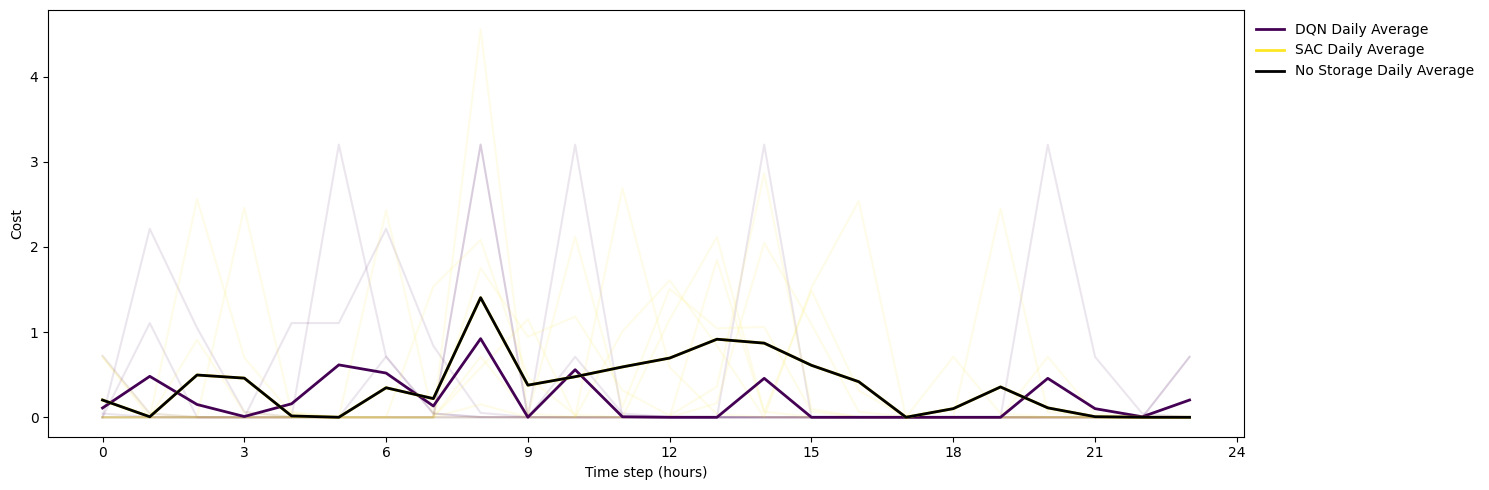

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

envs = {
    # "RBC": rbc_env,
    # "DQNR": dqnr_env,
    'DQN': dqn_env,
    'SAC': sac_env,
    # 'A2C': a2c_env,
    # 'DDPG': ddpg_env,
    # 'TD3': td3_env,
    # 'PPO': ppo_env
}

figsize = (15.0, 5)
fig, ax = plt.subplots(1, 1, figsize=figsize)

# Calculate daily averages
daily_averages = np.zeros((len(envs), 24))
for i, (k, v) in enumerate(envs.items()):
    y = v.energy_to_electrical_storage
    for j in range(7):  # 7 days in a week
        daily_averages[i] += y[j*24:(j+1)*24]
    daily_averages[i] /= 7

x = range(24)  # 24 hours in a day
colors = plt.cm.viridis(np.linspace(0, 1, len(envs)))
# Plot individual daily lines with opacity
for i, (k, v) in enumerate(envs.items()):
    y = v.energy_to_electrical_storage
    color = colors[i]
    for j in range(7):  # 7 days in a week
        ax.plot(x, y[j*24:(j+1)*24], color=color, alpha=0.1)

# Plot thick average line
for i, (k, v) in enumerate(envs.items()):
    color = colors[i]
    ax.plot(x, daily_averages[i], color=color, label=f'{k} Daily Average', linewidth=2)

# Calculate and plot daily averages for the baseline
y_baseline = v.energy_to_electrical_storage
baseline_daily_average = np.mean(y_baseline.reshape(-1, 24), axis=0)
ax.plot(range(24), baseline_daily_average, label='No Storage Daily Average', color='black', linewidth=2)

ax.set_xlabel('Time step (hours)')
ax.set_ylabel('Cost')
ax.xaxis.set_major_locator(ticker.MultipleLocator(3))  # Show ticks every 3 hours
ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0)

plt.tight_layout()
plt.show()